### Exercise 5

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import read_image
from torchinfo import summary

I don't know how to revive my dead kernel. Since all my cell outputs are still shown below I'm jsut going to leave it as is. I hope this is okay!

I chose the ResNet18 model because some surface-level research showed that since it is simple CNN with fewer parameters than other models, it faster to train & less prone to overfitting. It also apparently preforms well with the MNIST dataset, training to have high accuracy in only a few epochs. 

In [2]:
# Initializing model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Setting 'requires_grad' to false for all parameters in order to freeze layers 
# (modified from example)

for child in model.children():
    for param in child.parameters():
        param.requires_grad = False

Above, I found it necessary to freeze ALL the layers because the convolutional layers of the pre-trained ResNet18 model have already learned useful features that can be used for the MNIST dataset. 
By freezing them, I can prevent overfitting & also speed up training.

Modifying the fully connected layer is necessary, though, so that the model accounts for the 10 classes of the dataset. I also have to change the "Linear" layer to be "Conv.2d", because "Linear" is designed to deal with 1D data, and the MNIST dataset is 2D grayscale image data.

In [4]:
import torch.nn as nn
model.fc = nn.Linear(model.fc.in_features, 10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

The file names for the training/testing data are in csv files, while the actual images are in the "Images" folder.
I'm using this modified class to consolidate those & pre-process the image data.

In [5]:
import cv2 # Using the computer vision library becuase it makes using images easy
import numpy as np
import os

# (modified from INFO 3000 MP2)
class MNIST():

    def __init__(self, data, dir):
        self.data = data
        self.dir = dir

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):

        # Since the filenames & images are in different places, we have to consolidate them
        img_name = os.path.join(self.dir, self.data.iloc[idx, 0]) # Grabbing the image
        img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE) # Using cv2 to read the image
        label = self.data.iloc[idx, 1]

        # Resizing
        img = cv2.resize(img, (32, 32))

        # Normalizing and converting to a tensor
        img = img / 255.0
        img = torch.unsqueeze(torch.FloatTensor(img), 0)  # Add a single channel dimension

        label = torch.tensor(int(label))  # Convert label to a tensor

        return img, label

AttributeError: module 'cv2.dnn' has no attribute 'DictValue'

In [ ]:
import pandas as pd

# Importing dataset
train_csv = pd.read_csv('Mnist_Image_Data/train.csv')
test_csv = pd.read_csv('Mnist_Image_Data/test.csv')

train_data = MNIST(data=train_csv, dir="Mnist_Image_Data/Images/train")
test_data = MNIST(data=test_csv, dir="Mnist_Image_Data/Images/test")

# Amount of data - train and test while testing the __len__ method
print(train_data.__len__(),test_data.__len__())


49000 100


In [ ]:
from skimage import io,transform
from skimage.color import rgb2gray
from matplotlib import pyplot as plt

<class 'torch.Tensor'>
Shape of Imagetorch.Size([1, 32, 32]) datatype iamge: <class 'torch.Tensor'> datalabel: <class 'torch.Tensor'>
(32, 32)
torch.Size([])


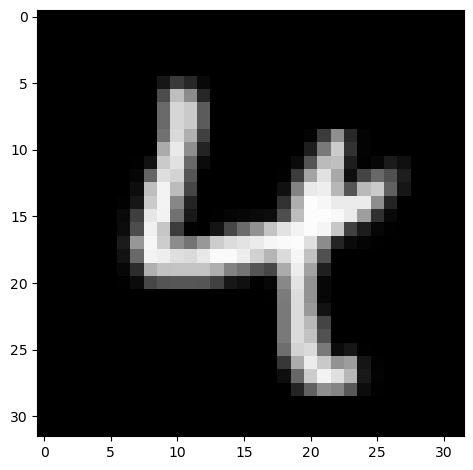

In [ ]:
# (modified from INFO 3000 MP2)
# Display an image while testing the __getitem__ method

# Get image from dataset
image1,label1 = train_data.__getitem__(20779)
print(type(label1))
print(f"Shape of Image{image1.shape} datatype iamge: {type(image1)} datalabel: {type(label1)}")

# Reshape image to make it plottable after converting to numpy array
image1 = (image1.numpy()).reshape(32,32)

# Check the shape of the image
print(image1.shape)
print(label1.shape)

# Display image
io.imshow(image1)
plt.show()

It looks like __getitem__ works! Now I have to train the model on the dataset.

In [ ]:
import torch.optim as optim

In [ ]:
# Defining the Data Loaders from the tested datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
num_epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

I've tried 3, 5, 8, 10, and 20 epochs and have found that 8 has the best accuracy:

In [ ]:
# Training the model
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/8, Loss: 1.2247027193752966
Epoch 2/8, Loss: 1.0340786939657076
Epoch 3/8, Loss: 0.9962596806160152
Epoch 4/8, Loss: 0.9850989089933451
Epoch 5/8, Loss: 0.9811189005020082
Epoch 6/8, Loss: 0.9803316162865093
Epoch 7/8, Loss: 0.9658899850384685
Epoch 8/8, Loss: 0.9719990796893446


In [ ]:
# Testing the model

correct = 0
total = 0

with torch.no_grad():

    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy}%")

Accuracy on test set: 70.0%


70% is still not the *best* accuracy, but I am satisfied with it.